In [122]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import random
import sys

In [123]:
data=open("names.txt","r").read().splitlines()

In [124]:
print(data[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [125]:
max=0
min=sys.maxsize
for i in data:
    if(len(i)>max):
        max=len(i)
    if(len(i)<min):
        min=len(i)
print(max)
print(min)

15
2


In [126]:
b={}
for w in data[:]:
    ch=['<S>']+list(w)+['<E>']
    for ch1,ch2 in zip(ch,ch[1:]):
        bigram=(ch1,ch2)
        b[bigram]=b.get(bigram,0)+1

In [127]:
import torch
print(torch.__version__)

2.7.1+cu126


In [128]:
N=torch.zeros((27,27),dtype=torch.int32)

In [129]:
chars = sorted(set(''.join(data)))  
chars =['.'] + chars     
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

In [130]:
for w in data:
    ch=['.']+list(w)+['.']
    for ch1,ch2 in zip(ch,ch[1:]):
        ix1=stoi[ch1]
        ix2=stoi[ch2]
        N[ix1,ix2]+=1

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

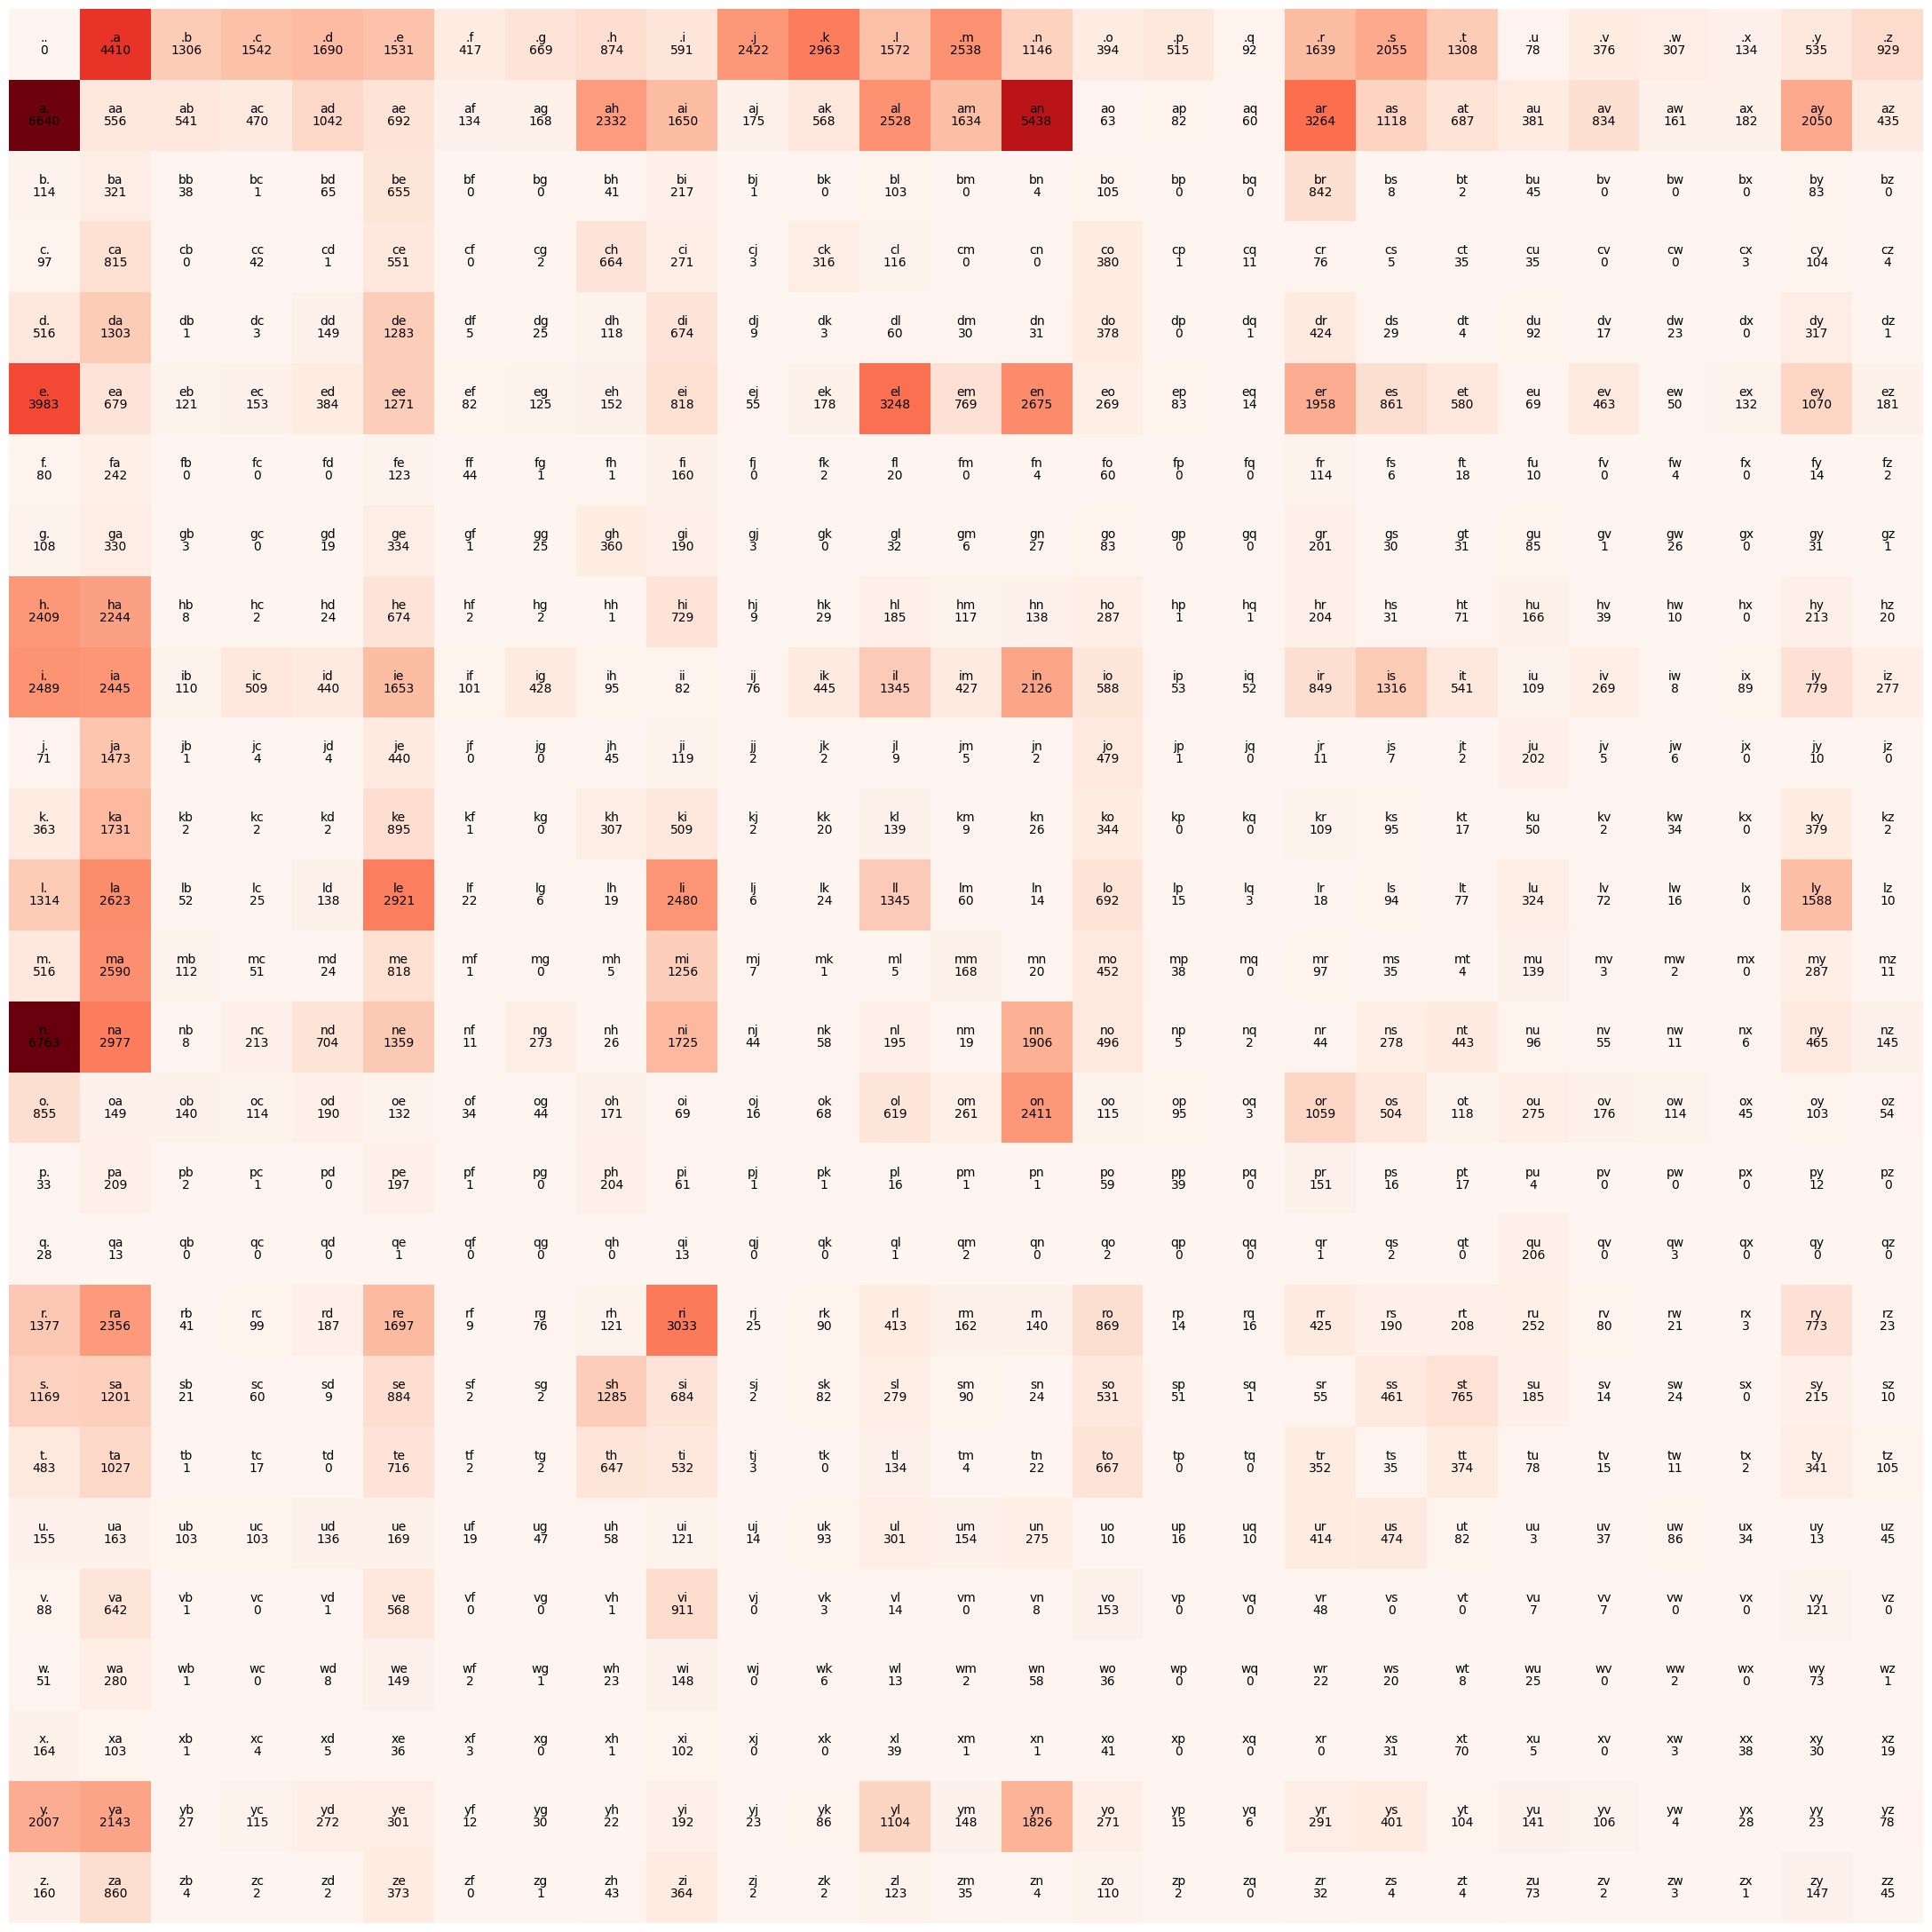

In [149]:
plt.figure(figsize=(28,28))
plt.imshow(N,cmap="Reds")
for i in range(len(itos)):
    for j in range(len(itos)):
        chrstr=itos[i]+itos[j]
        plt.text(j,i,chrstr,ha="center",va="bottom")
        plt.text(j,i,N[i,j].item(),ha="center",va="top")
plt.axis("off")

In [132]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [148]:
P=(N+1).float() #N+1 so that none of the probabilities are 0(none of the counts are 0)(For example 'jq'=>0 in count N)
P/=P.sum(1,keepdim=True) #this will store the probabilities of the count matrix N (Also look at broadcasting rules for tensor division)
for i in range(5):
    ix=0 #we start from 0 because the word would always start from '.'=>N[0] .(check the N matrix using pyplot)
    out=[]
    while(True):
        p=P[ix]
        ix=torch.multinomial(p, num_samples=1, replacement=True).item()  #Randomly generating a number from the list p
        out.append(itos[ix])
        if(ix==0): 
            break
    print(''.join(out))

ziavi.
ki.
jayrellyencksalos.
kass.
kynn.


In [157]:
#negative log likelihood (loss function)
log_likelihood=0
n=0
for w in data: #check for other names since the bigram is created (model is trained)
    ch=['.']+list(w)+['.']
    for ch1,ch2 in zip(ch,ch[1:]):
        ix1=stoi[ch1]
        ix2=stoi[ch2]
        prob=P[ix1,ix2]
        logprob=torch.log(prob)
        log_likelihood+=logprob
        n+=1
print(f'log likelihood={log_likelihood}')
print(f'negative log likelihood={-log_likelihood}')
print('average loss=',-log_likelihood/n)

log likelihood=-26.139978408813477
negative log likelihood=26.139978408813477
average loss= tensor(2.6140)


In [ ]:
#neural network approach
import torch.nn.functional as F
xs,ys=[],[]
for w in data[:1]:
    ch=['.']+list(w)+['.']
    for ch1,ch2 in zip(ch,ch[1:]):
        ix1=stoi[ch1]
        ix2=stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs=torch.tensor(xs)
ys=torch.tensor(ys)
xenc=F.one_hot(xs,num_classes=27).float()
W=torch.randn((27,27),requires_grad=True) #random based on normal probability distribution

In [ ]:
#forward pass
for i in range(100):
    logits=xenc@W # cross product (matrix multiplication)
    counts=logits.exp() #counts equal to N matrix above
    probs=counts/counts.sum(1,keepdims=True) #probabilities for next character
    #the last two lines are called softmax
    loss=-probs[torch.arange(5),ys].log().mean()+ 0.01*(W**2).mean() # This is L1 regularization (0.01 is the strength of regularization) 
    print(loss.item())
    W.grad=None
    #backward pass
    loss.backward()
    W.data-=100*W.grad

In [ ]:
for i in range(5):
    out=[]
    ix=0
    while True:
        xenc=F.one_hot(torch.tensor([ix]),num_classes=27).float()
        logits=xenc@W 
        counts=logits.exp() 
        p=counts/counts.sum(1,keepdims=True)
        ix=torch.multinomial(p,num_samples=1, replacement=True).item()
        out.append(itos[ix])
        if ix==0:
            break
    print(''.join(out))